In [1]:
import pandas as pd
import os, re
import matplotlib.pyplot as plt

In [2]:
#Define algumas variáveis

pasta_datasets = '../datasets/'
pasta_planilha = '../planilhas/'
planilha = 'Tab_Compl_CNT_4T20.xls'

In [3]:
try:
    os.mkdir(pasta_datasets)
    print(f'"Pasta {pasta_datasets} criada') 
except FileExistsError:
    print(f'"Pasta {pasta_datasets} já existe') 

"Pasta ../datasets/ já existe


In [4]:
# A planilha com os dados de interesse se chama "Valores Correntes" 
# O período está na coluna A e o PIB na coluna R, com valores a partir da linha 5
df = pd.read_excel(pasta_planilha+planilha, skiprows=3, usecols="A,R", sheet_name="Valores Correntes", 
                   names=('periodo','PIB'), dtype={'periodo':str})
df

,periodo,PIB
0,1995,7.059916e+05
1,1996.I,1.893233e+05
2,1996.II,2.046107e+05
3,1996.III,2.215132e+05
4,1996.IV,2.393163e+05
...,...,...
121,2020.I,1.843863e+06
122,2020.II,1.708760e+06
123,2020.III,1.891735e+06
124,2020.IV,2.003500e+06


In [5]:
df.dtypes

periodo     object
PIB        float64
dtype: object

In [6]:
# Observa-se que os dados estão disponíveis de forma trimestral em 04 linhas. Uma quinta linha realiza a consolidação anual
# Essas linhas de consolidação serão apagadas para não atrapalhar os modelos de previsão

# Deixar apenas as linhas que tenham o ".", exemplo "1996.I"
df_pib = df[df.periodo.str.contains('\.')].copy()

df_pib.reset_index(drop=True).head(8)

,periodo,PIB
0,1996.I,189323.299148
1,1996.II,204610.728455
2,1996.III,221513.234375
3,1996.IV,239316.345834
4,1997.I,219117.049382
5,1997.II,232889.544198
6,1997.III,246178.481097
7,1997.IV,253904.121411


In [7]:
# Função criada para transformar '1996.I' para formato datetime '1996-01-01'
def converte_trimestre(periodo):
    ano, num_trimestre = periodo.split('.')
    d_conversao = {'I': '-01', 'II':'-04', 'III': '-07', 'IV': '-10'}
    trimestre = pd.to_datetime(f'{ano}{d_conversao[num_trimestre]}')
    return trimestre

# Cria a columa data
df_pib['data'] = df_pib[['periodo']].applymap(converte_trimestre)

# Não é mais necessária a coluna periodo
df_pib.drop(columns='periodo', inplace=True)

df_pib.head()

,PIB,data
1,189323.299148,1996-01-01
2,204610.728455,1996-04-01
3,221513.234375,1996-07-01
4,239316.345834,1996-10-01
6,219117.049382,1997-01-01


In [8]:
# Cria nova dataframe para armazenar o PIB de forma mensal
df_pib_mensal = pd.DataFrame(columns=('data', 'PIB'))

# Alternativa adotada, transformar os valores em média
for i in range(0, len(df_pib)):
    pib_medio = df_pib.iloc[i]['PIB'] / 3
    mes = df_pib.iloc[i]['data']
    for j in range(0, 3):
        df_pib_mensal = df_pib_mensal.append({"PIB": pib_medio, "data": mes + pd.DateOffset(months=j)}, ignore_index=True)

df_pib_mensal.head()

,data,PIB
0,1996-01-01,63107.766383
1,1996-02-01,63107.766383
2,1996-03-01,63107.766383
3,1996-04-01,68203.576152
4,1996-05-01,68203.576152


In [9]:
# Transforma a coluna trimestre em índice
df_pib_mensal.set_index('data', inplace=True)

# Como a arrecadação foi recuperada no período de 2004 a 2019, o PIB deve estar disponível no mesmo período
df_pib_mensal = df_pib_mensal.loc['2004-01-01':'2019-12-01']

In [10]:
df_pib_mensal

,PIB
data,
2004-01-01,148261.162720
2004-02-01,148261.162720
2004-03-01,148261.162720
2004-04-01,160598.320168
2004-05-01,160598.320168
...,...
2019-08-01,628000.945482
2019-09-01,628000.945482
2019-10-01,641007.011815


In [11]:
df_pib_mensal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 192 entries, 2004-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PIB     192 non-null    float64
dtypes: float64(1)
memory usage: 3.0 KB


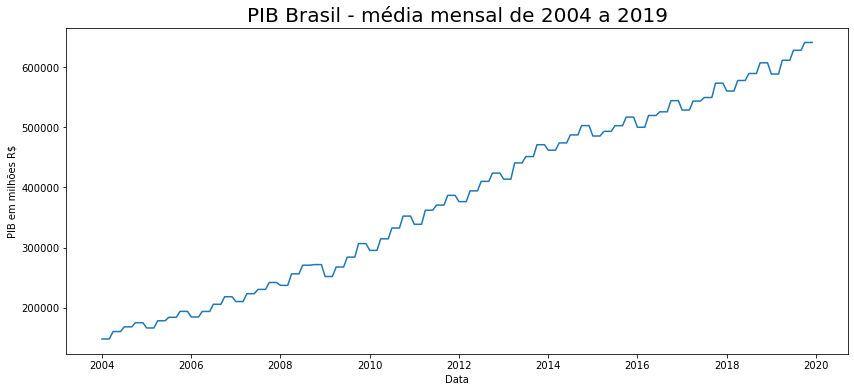

In [12]:
# Visualiza os dados do PIB ao longo do tempo
fig, ax = plt.subplots(figsize=(14, 6))
plt.rcParams['font.size'] = '10'
plt.title('PIB Brasil - média mensal de 2004 a 2019', fontdict={'size':20})
plt.ylabel('PIB em milhões R$')
plt.xlabel('Data')
plt.plot(df_pib_mensal)
ax.ticklabel_format(style='plain',  axis='y')
plt.show();


In [13]:
# Exporta em padrão CSV e Excel
df_pib_mensal.to_excel(pasta_planilha+'pib.xlsx', index=True)
df_pib_mensal.to_csv(pasta_datasets+'pib.csv', index=True)